<a href="https://colab.research.google.com/github/Ganesh-2250/NLP/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --inplace /content/NLP_Project.ipynb


[NbConvertApp] WARNING | pattern '/content/NLP_Project.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--ex

In [1]:
# Colab: install required packages
!pip install -q transformers datasets accelerate evaluate scikit-learn kaggle matplotlib seaborn gradio
# Make sure to use a recent versions of datasets/transformers
import transformers, datasets, evaluate, sklearn, sys
print("transformers", transformers.__version__)
print("datasets", datasets.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00
transformers 4.57.1
datasets 4.0.0


In [2]:
# Run this cell and upload kaggle.json when prompted
from google.colab import files
uploaded = files.upload()  # pick kaggle.json


Saving kaggle.json to kaggle.json


In [3]:
# put kaggle.json in right place and download dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the Amazon Reviews Multi dataset
!kaggle datasets download -d mexwell/amazon-reviews-multi -p /content --unzip
# This will produce CSV/TSV files in /content (check the file list)
!ls -lah /content | sed -n '1,120p'


Dataset URL: https://www.kaggle.com/datasets/mexwell/amazon-reviews-multi
License(s): other
 48% 63.0M/131M [00:00<00:00, 658MB/s]
100% 131M/131M [00:00<00:00, 688MB/s] 
total 347M
drwxr-xr-x 1 root root 4.0K Nov  2 13:39 .
drwxr-xr-x 1 root root 4.0K Nov  2 13:30 ..
drwxr-xr-x 4 root root 4.0K Oct 30 13:36 .config
drwx------ 5 root root 4.0K Nov  2 13:34 drive
-rw-r--r-- 1 root root   66 Nov  2 13:39 kaggle.json
drwxr-xr-x 1 root root 4.0K Oct 30 13:36 sample_data
-rw-r--r-- 1 root root 8.3M Nov  2 13:39 test.csv
-rw-r--r-- 1 root root 331M Nov  2 13:39 train.csv
-rw-r--r-- 1 root root 8.2M Nov  2 13:39 validation.csv


In [4]:
import os, glob, pandas as pd
data_files = glob.glob("/content/*amazon*/*") + glob.glob("/content/*amazon*.*") + glob.glob("/content/*.csv") + glob.glob("/content/*.tsv")
print("Possible files:", data_files[:40])

# Example: open a CSV/TSV. If files are per-language (e.g., en.csv, de.csv), load them separately.
# Modify the filename below if necessary after inspecting the list.
# We'll load only the languages we care about into pandas DataFrames.


Possible files: ['/content/train.csv', '/content/test.csv', '/content/validation.csv']


In [5]:
import re
from datasets import Dataset

# Example logic — adapt file names after inspecting actual downloaded file names.
# Some Kaggle datasets come with separate files like amazon_reviews_multi-en.csv, amazon_reviews_multi-de.csv, etc.
# Adjust the filenames below to your actual files.

# Find files with language codes in filename
files = [f for f in data_files if re.search(r'(\.en|_en|-en|/en\.)', f) or re.search(r'(\.de|_de|-de|/de\.)', f)]
print("Matched sample files:", files[:10])

# Generic loader to attempt CSV and TSV
def load_lang_file(path):
    if path.endswith('.csv'):
        return pd.read_csv(path, low_memory=False)
    elif path.endswith('.tsv'):
        return pd.read_csv(path, sep='\t', low_memory=False)
    else:
        # fallback: try pandas read_table
        return pd.read_table(path, low_memory=False)

# If the dataset contains named files per language, load them explicitly:
# lang_files = {}
# for path in sorted(os.listdir('/content')):
#     low = path.lower()
#     if 'en' in low and 'amazon' in low:
#         lang_files['en'] = '/content/' + path
#     if 'de' in low and 'amazon' in low:
#         lang_files['de'] = '/content/' + path
#     if 'fr' in low and 'amazon' in low:
#         lang_files['fr'] = '/content/' + path
#     if 'ja' in low and 'amazon' in low:
#         lang_files['ja'] = '/content/' + path

# print("Detected language files:", lang_files)
# if not auto-detected, manually set filenames here:
# lang_files = {'en':'/content/amazon_reviews_en.csv', 'de':'/content/amazon_reviews_de.csv', ...}

# --- MODIFIED LOGIC TO LOAD AVAILABLE CSVs ---
dfs = {}
main_files = {
    'train': '/content/train.csv',
    'test': '/content/test.csv',
    'validation': '/content/validation.csv'
}

# Load the main CSVs first
main_dfs = {}
for name, path in main_files.items():
    if os.path.exists(path):
        print(f"Loading {name} from {path}")
        df = load_lang_file(path)
        main_dfs[name] = df
        print(f"{name} rows:", len(df))
    else:
        print(f"Warning: {path} not found.")

# Assuming a 'language' or 'lang' column exists in the main dataframes to split by language
# If no such column exists, we might process the whole dataset as one or focus on a single language if known.
# Based on the dataset description, it should have a 'language' column.
if main_dfs and 'language' in list(main_dfs.values())[0].columns:
    all_data = pd.concat(main_dfs.values(), ignore_index=True)
    print("Combined data columns:", all_data.columns.tolist())

    # Normalize column names
    text_cols = [c for c in all_data.columns if c.lower() in ['review_body','reviewtext','review','text','review_text','review_body_text']]
    rating_cols = [c for c in all_data.columns if 'star' in c.lower() or 'rating' in c.lower() or 'label' in c.lower()]

    if not text_cols:
        print("Error: Could not find text column.")
    elif not rating_cols:
        print("Error: Could not find rating column.")
    else:
        text_col = text_cols[0]
        rating_col = rating_cols[0]
        print("Using text_col:", text_col, "rating_col:", rating_col)

        all_data = all_data.rename(columns={text_col:'review_body', rating_col:'stars'})

        # If stars are 0-4 convert to 1-5 if necessary (common variants for this dataset)
        # Check the value range before converting
        if all_data['stars'].dropna().astype(float).max() <= 4.0:
             print("Converting 0-4 star rating to 1-5")
             all_data['stars'] = all_data['stars'].astype(float) + 1.0

        # Split by language and store in dfs
        for lang_code in all_data['language'].unique():
            lang_df = all_data[all_data['language'] == lang_code].copy()
            # Select relevant columns and drop NaNs
            dfs[lang_code] = lang_df[['review_body', 'stars']].dropna(subset=['review_body', 'stars']).reset_index(drop=True)
            print(f"Loaded language '{lang_code}' rows: {len(dfs[lang_code])}")

else:
    print("Warning: Could not find 'language' column or no data loaded. Processing all data together if possible.")
    # Fallback: if no language column, treat all data as one
    if main_dfs:
        all_data = pd.concat(main_dfs.values(), ignore_index=True)
        text_cols = [c for c in all_data.columns if c.lower() in ['review_body','reviewtext','review','text','review_text','review_body_text']]
        rating_cols = [c for c in all_data.columns if 'star' in c.lower() or 'rating' in c.lower() or 'label' in c.lower()]

        if text_cols and rating_cols:
            text_col = text_cols[0]
            rating_col = rating_cols[0]
            all_data = all_data.rename(columns={text_col:'review_body', rating_col:'stars'})
            if all_data['stars'].dropna().astype(float).max() <= 4.0:
                 print("Converting 0-4 star rating to 1-5")
                 all_data['stars'] = all_data['stars'].astype(float) + 1.0
            dfs['all'] = all_data[['review_body', 'stars']].dropna(subset=['review_body', 'stars']).reset_index(drop=True)
            print(f"Loaded combined data rows: {len(dfs['all'])}")
        else:
             print("Error: Could not find required columns in combined data.")


# Quick check
for lang, df in dfs.items():
    print(lang, df.head(2).to_dict(orient='records'))

Matched sample files: []
Loading train from /content/train.csv
train rows: 1200000
Loading test from /content/test.csv
test rows: 30000
Loading validation from /content/validation.csv
validation rows: 30000
Combined data columns: ['Unnamed: 0', 'review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category']
Using text_col: review_body rating_col: stars
Loaded language 'de' rows: 210000
Loaded language 'en' rows: 210000
Loaded language 'es' rows: 210000
Loaded language 'fr' rows: 210000
Loaded language 'ja' rows: 210000
Loaded language 'zh' rows: 210000
de [{'review_body': 'Armband ist leider nach 1 Jahr kaputt gegangen', 'stars': 1}, {'review_body': 'In der Lieferung war nur Ein Akku!', 'stars': 1}]
en [{'review_body': "Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twic

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

def map_label(stars):
    s = int(round(float(stars)))
    if s <= 2:
        return 0
    elif s == 3:
        return 1
    else:
        return 2

for lang, df in dfs.items():
    df['label'] = df['stars'].apply(map_label)
    # Select subset for quick experiments: 5000 train, 1000 test (or as available)
    # We'll stratify by label to keep balanced sets
    n_train = min(5000, len(df)-1000)
    if n_train <= 0:
        print(f"Not enough data for {lang}, skipping")
        continue
    train_df, test_df = train_test_split(df, test_size=1000, stratify=df['label'], random_state=42)
    train_df = train_df.sample(n=n_train, random_state=42)
    # Save to disk as CSV for reproducibility
    train_out = f"/content/{lang}_train.csv"
    test_out = f"/content/{lang}_test.csv"
    train_df.to_csv(train_out, index=False)
    test_df.to_csv(test_out, index=False)
    print(f"Saved {lang} train {train_out} ({len(train_df)} rows), test {test_out} ({len(test_df)} rows)")


Saved de train /content/de_train.csv (5000 rows), test /content/de_test.csv (1000 rows)
Saved en train /content/en_train.csv (5000 rows), test /content/en_test.csv (1000 rows)
Saved es train /content/es_train.csv (5000 rows), test /content/es_test.csv (1000 rows)
Saved fr train /content/fr_train.csv (5000 rows), test /content/fr_test.csv (1000 rows)
Saved ja train /content/ja_train.csv (5000 rows), test /content/ja_test.csv (1000 rows)
Saved zh train /content/zh_train.csv (5000 rows), test /content/zh_test.csv (1000 rows)


In [7]:
from datasets import load_dataset, DatasetDict, concatenate_datasets, Dataset

dataset_langs = {}
for lang in dfs.keys():
    train_path = f"/content/{lang}_train.csv"
    test_path  = f"/content/{lang}_test.csv"
    if not (os.path.exists(train_path) and os.path.exists(test_path)):
        continue
    ds_train = load_dataset('csv', data_files=train_path, split='train')
    ds_test  = load_dataset('csv', data_files=test_path, split='train')  # csv loader loads a single file as 'train' split here
    dataset_langs[lang] = DatasetDict({'train': ds_train, 'test': ds_test})
    print(lang, "->", len(ds_train), len(ds_test))

# Example: create a combined multilingual train/test
combined_train = concatenate_datasets([d['train'] for d in dataset_langs.values()])
combined_test  = concatenate_datasets([d['test'] for d in dataset_langs.values()])
print("Combined sizes:", len(combined_train), len(combined_test))


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

de -> 5000 1000


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

en -> 5000 1000


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

es -> 5000 1000


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

fr -> 5000 1000


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

ja -> 5000 1000


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

zh -> 5000 1000
Combined sizes: 30000 6000


In [8]:
from transformers import AutoTokenizer

# Example: choose model name variable before training
MODEL_NAME = "bert-base-uncased"   # change to "xlm-roberta-base" for multilingual run
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenization function
def preprocess(batch):
    return tokenizer(batch['review_body'], truncation=True, padding='max_length', max_length=256)

# Tokenize datasets (do for both combined_train/combined_test or per-language datasets)
tok_train = combined_train.map(preprocess, batched=True)
tok_test  = combined_test.map(preprocess, batched=True)

# Set labels and format for Trainer
tok_train = tok_train.rename_column("label", "labels")
tok_test  = tok_test.rename_column("label", "labels")
tok_train.set_format(type="torch", columns=['input_ids','attention_mask','labels'])
tok_test.set_format(type="torch", columns=['input_ids','attention_mask','labels'])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [9]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import evaluate

acc_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        'accuracy': acc_metric.compute(predictions=preds, references=labels)['accuracy'],
        'f1_macro': f1_metric.compute(predictions=preds, references=labels, average='macro')['f1'],
        'f1_micro': f1_metric.compute(predictions=preds, references=labels, average='micro')['f1']
    }

def train_model(model_name, train_dataset, eval_dataset, outdir, epochs=2, batch_size=16, lr=2e-5):
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
    training_args = TrainingArguments(
        output_dir=outdir,
        # evaluation_strategy="epoch", # old argument name
        eval_strategy="epoch", # new argument name
        save_strategy="epoch",
        # logging_strategy="steps", # old argument name
        logging_steps=200, # new argument name
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        learning_rate=lr,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        fp16=True
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer
    )
    trainer.train()
    return trainer

In [10]:
# Train monolingual BERT on combined_train (or restrict to English-only for monolingual)
# If you want true monolingual experiment: use only the English split below:
english_train = dataset_langs['en']['train'] if 'en' in dataset_langs else combined_train
english_test  = dataset_langs['en']['test'] if 'en' in dataset_langs else combined_test

# Tokenize english datasets (if not already tokenized)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tok_en_train = english_train.map(lambda b: tokenizer(b['review_body'], truncation=True, padding='max_length', max_length=256), batched=True)
tok_en_test  = english_test.map(lambda b: tokenizer(b['review_body'], truncation=True, padding='max_length', max_length=256), batched=True)
tok_en_train = tok_en_train.rename_column("label","labels")
tok_en_test  = tok_en_test.rename_column("label","labels")
tok_en_train.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
tok_en_test.set_format(type='torch', columns=['input_ids','attention_mask','labels'])

# Train
trainer_bert = train_model("bert-base-uncased", tok_en_train, tok_en_test, outdir="/content/bert_monolingual", epochs=2, batch_size=16)
trainer_bert.evaluate()


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2697262762.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ganeshiitb317 (ganeshiitb317-iit-bombay) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro
1,0.772400,0.629933,0.732000,0.664587,0.732000
2,0.514100,0.637917,0.735000,0.678664,0.735000


{'eval_loss': 0.6379169225692749,
 'eval_accuracy': 0.735,
 'eval_f1_macro': 0.6786644238526,
 'eval_f1_micro': 0.735,
 'eval_runtime': 3.5145,
 'eval_samples_per_second': 284.536,
 'eval_steps_per_second': 17.926,
 'epoch': 2.0}

In [11]:
# Train xlm-roberta-base on the combined multilingual train/test
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
tok_comb_train = combined_train.map(lambda b: tokenizer(b['review_body'], truncation=True, padding='max_length', max_length=256), batched=True)
tok_comb_test  = combined_test.map(lambda b: tokenizer(b['review_body'], truncation=True, padding='max_length', max_length=256), batched=True)
tok_comb_train = tok_comb_train.rename_column("label","labels")
tok_comb_test  = tok_comb_test.rename_column("label","labels")
tok_comb_train.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
tok_comb_test.set_format(type='torch', columns=['input_ids','attention_mask','labels'])

trainer_xlm = train_model("xlm-roberta-base", tok_comb_train, tok_comb_test, outdir="/content/xlm_multilingual", epochs=2, batch_size=8, lr=2e-5)
trainer_xlm.evaluate()


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2697262762.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro
1,0.624400,0.644652,0.742333,0.676940,0.742333
2,0.542500,0.645775,0.742000,0.683463,0.742000


{'eval_loss': 0.6457749009132385,
 'eval_accuracy': 0.742,
 'eval_f1_macro': 0.6834633848462999,
 'eval_f1_micro': 0.742,
 'eval_runtime': 22.9994,
 'eval_samples_per_second': 260.876,
 'eval_steps_per_second': 32.61,
 'epoch': 2.0}

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

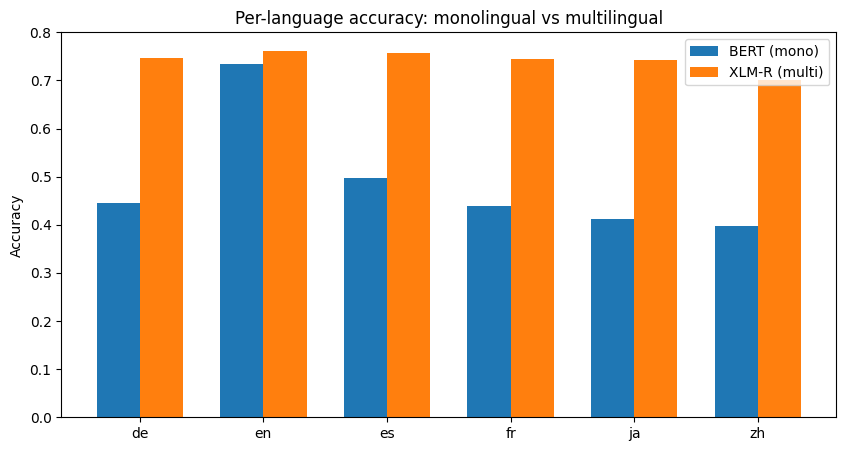

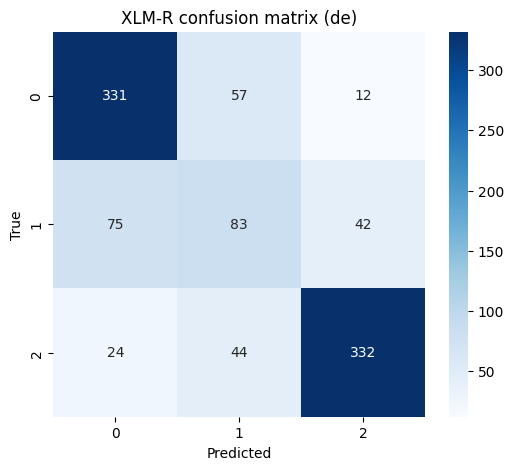

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def eval_trainer_by_lang(trainer, tokenizer, dataset_langs):
    results = {}
    for lang, dd in dataset_langs.items():
        ds = dd['test']
        tok_ds = ds.map(lambda b: tokenizer(b['review_body'], truncation=True, padding='max_length', max_length=256), batched=True)
        tok_ds = tok_ds.rename_column('label','labels')
        tok_ds.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
        preds = trainer.predict(tok_ds)
        y_pred = np.argmax(preds.predictions, axis=-1)
        y_true = preds.label_ids
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        cm = confusion_matrix(y_true, y_pred)
        results[lang] = {'report': report, 'confusion_matrix': cm, 'y_true': y_true, 'y_pred': y_pred}
    return results

# Evaluate both
results_bert = eval_trainer_by_lang(trainer_bert, AutoTokenizer.from_pretrained("bert-base-uncased"), dataset_langs)
results_xlm  = eval_trainer_by_lang(trainer_xlm, AutoTokenizer.from_pretrained("xlm-roberta-base"), dataset_langs)

# Visualize per-language accuracy (bar chart)
langs = sorted(results_xlm.keys())
bert_acc = [results_bert.get(l,{'report':{'accuracy':0}})['report'].get('accuracy', 0) for l in langs]
xlm_acc  = [results_xlm[l]['report'].get('accuracy',0) for l in langs]

x = np.arange(len(langs))
width = 0.35
plt.figure(figsize=(10,5))
plt.bar(x - width/2, bert_acc, width, label='BERT (mono)')
plt.bar(x + width/2, xlm_acc, width, label='XLM-R (multi)')
plt.xticks(x, langs)
plt.ylabel('Accuracy')
plt.title('Per-language accuracy: monolingual vs multilingual')
plt.legend()
plt.show()

# Plot confusion matrix for a single language example (e.g., 'ja' if exists)
lang_example = langs[0]
cm = results_xlm[lang_example]['confusion_matrix']
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'XLM-R confusion matrix ({lang_example})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [14]:
def show_mismatch_examples(results, dataset_langs, num=5):
    for lang, vals in results.items():
        y_true = vals['y_true']
        y_pred = vals['y_pred']
        ds = dataset_langs[lang]['test']
        mismatches = np.where(y_true != y_pred)[0]
        print(f"Language {lang}: {len(mismatches)} mismatches (showing up to {num})")
        for i in mismatches[:num]:
            print("----")
            # Convert numpy.int64 to int for dataset access
            print("Text:", ds[int(i)]['review_body'][:400].replace('\n',' '))
            print("True:", y_true[i], "Pred:", y_pred[i])
        print("\n")

# Example: show mismatches for XLM-R
show_mismatch_examples(results_xlm, dataset_langs, num=3)

Language de: 254 mismatches (showing up to 3)
----
Text: Beständig aber auf dauer nicht überzeugend! Das Handy ist nun 1,5 Jahre alt. Ladebuchse nimmt das kabel welches ich 3 mal gewechselt hab bedingt an!Zudem nervt es gewaltig das das Kabel obwohl richtig eingesteckt beim laden rausrutscht! Und das obwohl nichts gemacht wurde. Microfon des öfteren gesäubert und trotzdem hin! Dies mag eine ausnahme sein! Ich hatte ein Jahr ziemlichen spass an den Handy
True: 0 Pred: 1
----
Text: Meine ursprünglichen 5 Sterne habe ich auf 2 reduziert, weil meine TIMEX Ironman wenige Monate nach Ablauf der Garantie bei normalem Wassereinsatz (Schwimmen usw.), wie meine zwei vorherigen CASIO-Modelle undicht geworden ist. Vorteile der TIMEX-Uhr: Armband mit Verschlusssicherung, Große Zahlen, d.h. ich kann meine Brille zu Hause lassen.
True: 0 Pred: 2
----
Text: Fingerabdrucksensor lässt sich schlecht lesen
True: 2 Pred: 0


Language en: 238 mismatches (showing up to 3)
----
Text: Pretty Wig, too long for 

In [15]:
import gradio as gr
from transformers import pipeline

# Load best multilingual model from trainer_xlm
best_model_path = "/content/xlm_multilingual/checkpoint-best"  # adjust to actual saved best checkpoint path from Trainer
# If Trainer saved to /content/xlm_multilingual, find the best model dir, or use trainer_xlm.model
pipe = pipeline("text-classification", model=trainer_xlm.model, tokenizer=AutoTokenizer.from_pretrained("xlm-roberta-base"), return_all_scores=False)

def predict(text):
    out = pipe(text[:1000])  # truncate long inputs
    # pipeline returns label like 'LABEL_0' — map to friendly names
    label_map = {'LABEL_0':'negative','LABEL_1':'neutral','LABEL_2':'positive'}
    label = out[0]['label']
    score = out[0]['score']
    return label_map.get(label,label), float(score)

demo = gr.Interface(fn=predict, inputs=gr.Textbox(lines=4, placeholder="Type a review in any language..."), outputs=["text","number"], title="Multilingual Sentiment Demo")
demo.launch(share=True)


Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f62dc257b4d702aa46.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
